In [1]:
!pip install --use-pep517 -q nb_black
%load_ext lab_black

!pip install -q praw
!pip install -q cryptography
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q pandas
!pip install -q numpy
!pip install -q scipy
!pip install -q torch torchvision torchaudio
!pip install -q termcolor
!pip install -q matplotlib
!pip install -q tqdm

In [2]:
import pandas as pd
import numpy as np
import praw
import os
from cryptography.fernet import Fernet
import transformers
from scipy.special import softmax
from termcolor import colored
from DataFetcher import fetch_data
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

C:\Users\egorf\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define static variables
SUBREDDIT = "pathofexile"
TIME_PERIOD = timedelta(days=360)
DATE = datetime.today()
STORAGE_FOLDER = "predictions"

# get data from Pushshift API
data_file = fetch_data(SUBREDDIT, TIME_PERIOD, DATE)

Fetching data... current submission count: 70784 day 359/360

In [4]:
# load data to dataframe
data = pd.read_csv(data_file)
data.head()

,timestamp,title
0,1682114921,PSA: All modifiers to the duration of self-inf...
1,1682114592,"Rage Vortex isn't really invisible, it's just ..."
2,1682113947,The luckiest craft I've ever done
3,1682113692,Looking for a new build
4,1682113282,The main Reason i play POE is the balanced gam...


In [5]:
# convert timestamp column to datetime
data["datetime"] = pd.to_datetime(data["timestamp"], unit="s")
data = data.drop("timestamp", axis=1)
data.head()

,title,datetime
0,PSA: All modifiers to the duration of self-inf...,2023-04-21 22:08:41
1,"Rage Vortex isn't really invisible, it's just ...",2023-04-21 22:03:12
2,The luckiest craft I've ever done,2023-04-21 21:52:27
3,Looking for a new build,2023-04-21 21:48:12
4,The main Reason i play POE is the balanced gam...,2023-04-21 21:41:22


In [6]:
MAX_LENGTH = 514


# Preprocess text (username and link placeholders)
def preprocess(text):
    text = text[:MAX_LENGTH]
    new_text = []
    for t in text.split(" "):
        t = "@user" if t.startswith("u/") and len(t) > 1 else t
        t = "http" if t.startswith("http") else t
        new_text.append(t)
    return " ".join(new_text)


# download the model from huggingface.co
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL, use_fast=False)
config = transformers.AutoConfig.from_pretrained(MODEL)

# save the model
model = transformers.AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)

('cardiffnlp/twitter-xlm-roberta-base-sentiment\\tokenizer_config.json',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\special_tokens_map.json',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\sentencepiece.bpe.model',
 'cardiffnlp/twitter-xlm-roberta-base-sentiment\\added_tokens.json')

In [7]:
score_labels = {
    2: "Positive",
    1: "Neutral",
    0: "Negative",
}


def get_verdict(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    output = model(**encoded_input)
    score = output[0][0].detach().numpy()
    score = softmax(score)
    return score_labels[np.argmax(score)]


# get predictions, put it to "verdict" column
tqdm.pandas()
data["title"] = data["title"].apply(preprocess)
data["verdict"] = data["title"].progress_apply(get_verdict)
data.head()

100%|██████████████████████████████████████████████████████████████████████████| 70784/70784 [1:10:50<00:00, 16.65it/s]


,title,datetime,verdict
0,PSA: All modifiers to the duration of self-inf...,2023-04-21 22:08:41,Negative
1,"Rage Vortex isn't really invisible, it's just ...",2023-04-21 22:03:12,Neutral
2,The luckiest craft I've ever done,2023-04-21 21:52:27,Positive
3,Looking for a new build,2023-04-21 21:48:12,Neutral
4,The main Reason i play POE is the balanced gam...,2023-04-21 21:41:22,Positive


In [8]:
# store predictions
folder = os.path.join(STORAGE_FOLDER, SUBREDDIT)
if not os.path.exists(folder):
    os.makedirs(folder)
file_path = folder + "/submissions.csv"
data.to_csv(file_path)

del data

(array([23310.,     0.,     0.,     0.,     0., 38324.,     0.,     0.,
            0.,  9150.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

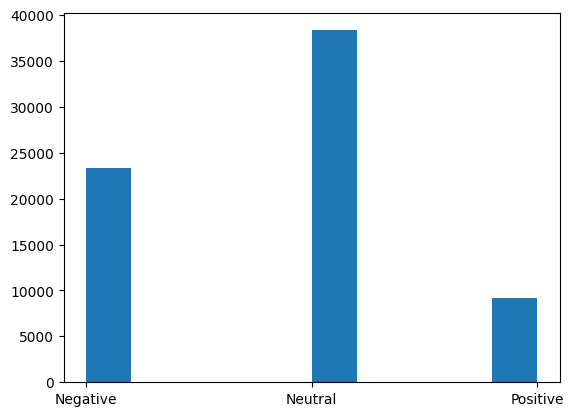

In [9]:
# load predictions
folder = os.path.join(STORAGE_FOLDER, SUBREDDIT)
file_path = folder + "/submissions.csv"
data = pd.read_csv(file_path)

data["datetime"] = pd.to_datetime(data["datetime"])

plt.hist(data["verdict"])

<Axes: xlabel='datetime'>

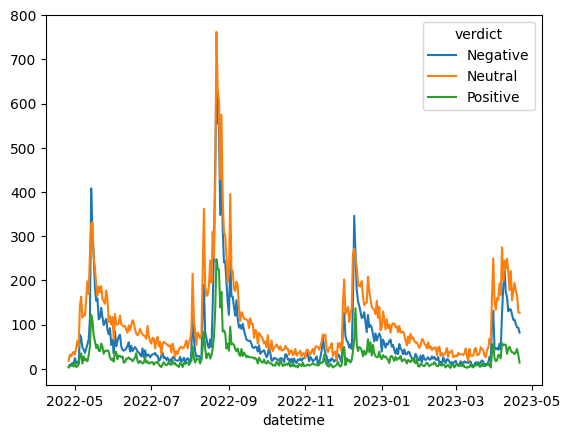

In [10]:
by_date = data.groupby(["verdict", data["datetime"].dt.date]).size()

pivot = by_date.reset_index().pivot_table(
    index="datetime", columns="verdict", values=0, fill_value=0
)
pivot.plot.line()